In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
import cv2
import random

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(f"Using TensorFlow version: {tf.__version__}")



Using TensorFlow version: 2.15.0


In [2]:
# Classes
classes = ['admin', 'ansci', 'coe', 'dcst', 'dss', 'dthm', 'foodtech', 'forestry', 'gym']

# Arrays to hold images and labels
X_train, Z_train = [], []
X_val, Z_val = [], []
X_test, Z_test = [], []

def assign_label(building_type):
    building_type = building_type.lower()
    if building_type in classes:
        return classes.index(building_type)
    else:
        print(f"Warning: Unrecognized building type: {building_type}")
        return None

# Dataset path
project_dir = os.getcwd()
inputdataset = os.path.join(project_dir, "dataset")

# Load images
def load_images_from_folder(folder_path, X, Z):
    for building in os.listdir(folder_path):
        building_path = os.path.join(folder_path, building)
        if not os.path.isdir(building_path):
            continue
        label = assign_label(building)
        if label is None:
            continue
        for filename in os.listdir(building_path):
            img_path = os.path.join(building_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.resize(img, (150,150))
            img = img / 255.0
            X.append(img)
            Z.append(label)

# Load datasets
load_images_from_folder(os.path.join(inputdataset, 'training'), X_train, Z_train)
load_images_from_folder(os.path.join(inputdataset, 'validation'), X_val, Z_val)
load_images_from_folder(os.path.join(inputdataset, 'testing'), X_test, Z_test)

# Convert to numpy arrays
X_train, Z_train = np.array(X_train), np.array(Z_train)
X_val, Z_val = np.array(X_val), np.array(Z_val)
X_test, Z_test = np.array(X_test), np.array(Z_test)

# One-hot encoding
Y_train = to_categorical(Z_train, len(classes))
Y_val = to_categorical(Z_val, len(classes))
Y_test = to_categorical(Z_test, len(classes))

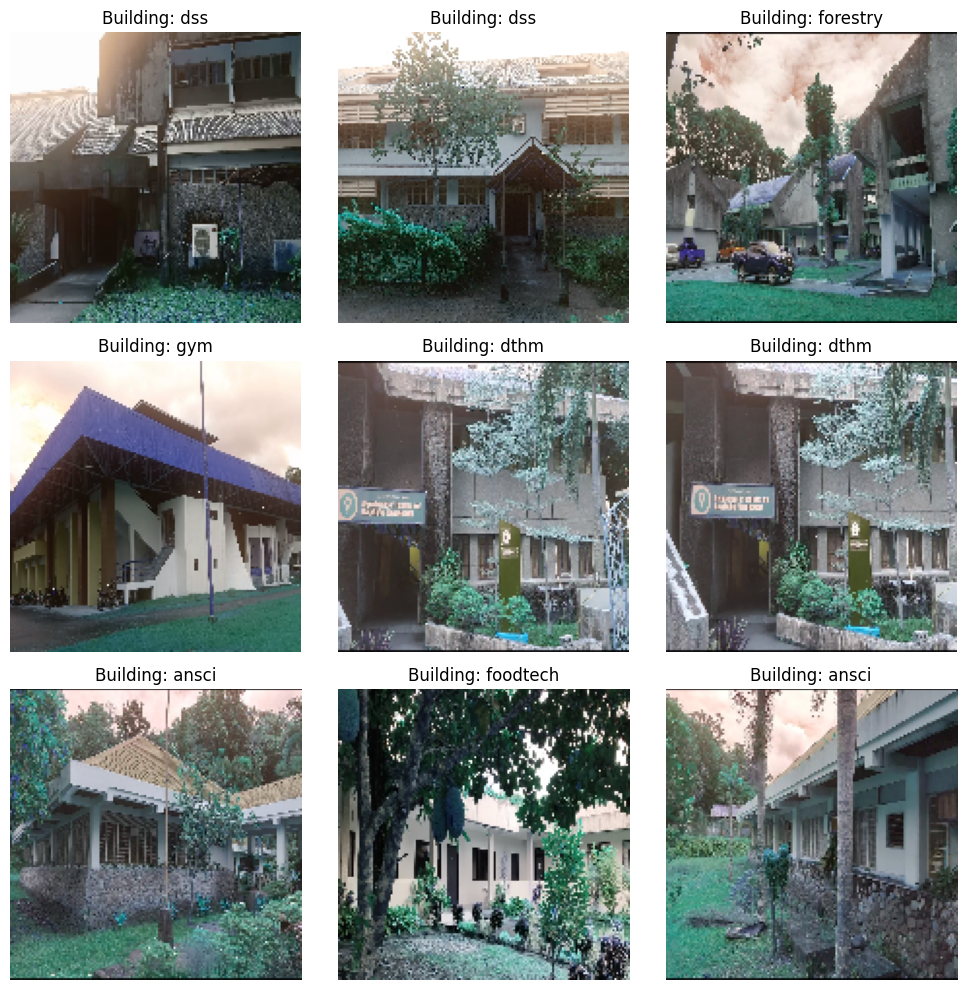

In [3]:
# Visualize random training samples
figure, axes = plt.subplots(3, 3)
figure.set_size_inches(10, 10)
for row in range(3):
    for col in range(3):
        index = random.randint(0, len(X_train) - 1)
        image = X_train[index]
        building_label = Z_train[index]
        axes[row, col].imshow(image)
        axes[row, col].set_title(f"Building: {classes[building_label]}")
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [4]:
# ✅ Load MobileNetV2 as base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # Freeze base layers

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Summary
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

In [6]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model_mobilenetv2.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)


In [7]:
# ✅ Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    epochs=40,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/40


57/57 [==============================] - 44s 630ms/step - loss: 1.4487 - accuracy: 0.5264 - val_loss: 0.6951 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 2/40
57/57 [==============================] - 26s 460ms/step - loss: 0.5473 - accuracy: 0.8234 - val_loss: 0.3643 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 3/40
57/57 [==============================] - 27s 468ms/step - loss: 0.3778 - accuracy: 0.8890 - val_loss: 0.3530 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 4/40
57/57 [==============================] - 28s 491ms/step - loss: 0.2698 - accuracy: 0.9128 - val_loss: 0.2749 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 5/40
57/57 [==============================] - 31s 548ms/step - loss: 0.2262 - accuracy: 0.9334 - val_loss: 0.2321 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 6/40
57/57 [==============================] - 52s 912ms/step - loss: 0.1764 - accuracy: 0.9450 - val_loss: 0.2395 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 7/40
57/57 [==============================] - 31s 550ms/

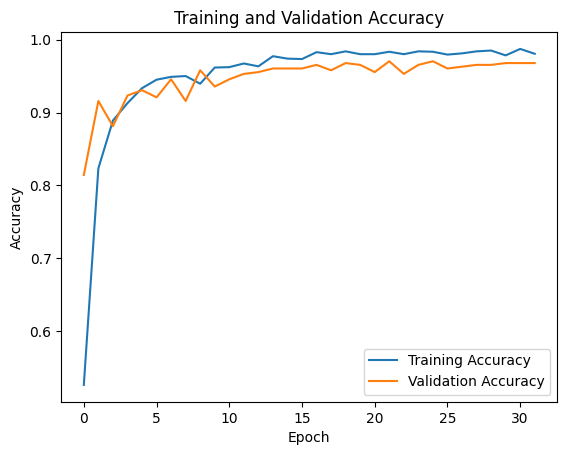

In [8]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

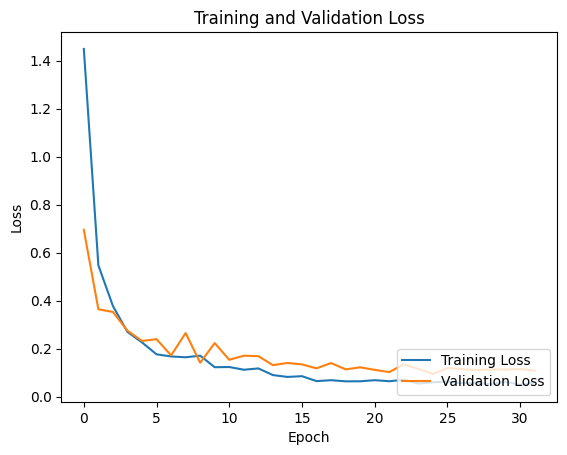

13/13 [==============================] - 5s 362ms/step - loss: 0.0945 - accuracy: 0.9703


In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')  
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()
val_loss, val_acc = model.evaluate(X_val, Y_val)

In [11]:
model = tf.keras.models.load_model('best_model_mobilenetv2.keras')

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Final Test Accuracy: {test_acc:.2f}")


13/13 [==============================] - 9s 297ms/step - loss: 0.0921 - accuracy: 0.9753
Final Test Accuracy: 0.98


In [12]:
model.save('final_model.keras')

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = r"C:\Users\Leonilo Molar\Downloads\sample\dthm001.png"

# Load the image with the same size as the model's input size
img = load_img(image_path, target_size=(150, 150))  # Adjust (224, 224) to your model's input size
img_array = img_to_array(img)  # Convert image to a NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize to [0, 1] if your model expects normalized input

print(f"Image shape after preprocessing: {img_array.shape}")
model = tf.keras.models.load_model('final_model.keras')

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index
confidence = np.max(predictions)  # Get confidence score

# Print the class name and confidence
print(f"Predicted building name: {classes[predicted_class]}")
print(f"Confidence: {confidence:.2f}")

Image shape after preprocessing: (1, 150, 150, 3)
1/1 [==============================] - 2s 2s/step
Predicted building name: foodtech
Confidence: 0.88
